# 用Tensorflow进行中文自然语言处理--情感分析

$$f('真好喝')=1$$
$$f('太难喝了')=0$$

**需要的库**  
numpy  
jieba  
gensim  
tensorflow  
matplotlib  

In [1]:
# 首先加载必用的库
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
# 用来解压
import bz2

**预训练词向量**  
本教程使用了北京师范大学中文信息处理研究所与中国人民大学 DBIIR 实验室的研究者开源的"chinese-word-vectors" github链接为：  
https://github.com/Embedding/Chinese-Word-Vectors  
如果你不知道word2vec是什么，我推荐以下一篇文章：  
https://zhuanlan.zhihu.com/p/26306795  
这里我们使用了"chinese-word-vectors"知乎Word + Ngram的词向量，可以从上面github链接下载，我们先加载预训练模型并进行一些简单测试：

In [2]:
# 请将下载的词向量压缩包放置在根目录 embeddings 文件夹里
# 解压词向量, 有可能需要等待1-2分钟
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [3]:
# 使用gensim加载预训练中文分词embedding, 有可能需要等待1-2分钟
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram', 
                                             binary=False, unicode_errors="ignore")

**词向量模型**  
在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量，我们今天需要构建的LSTM神经网络模型并不能直接处理汉字文本，需要先进行分次并把词汇转换为词向量，步骤请参考下图，步骤的讲解会跟着代码一步一步来，如果你不知道RNN，GRU，LSTM是什么，我推荐deeplearning.ai的课程，网易公开课有免费中文字幕版，但我还是推荐有习题和练习代码部分的的coursera原版：  
<img src='flowchart.jpg' style='width:400px;'>

In [4]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['山东大学'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['山东大学']

词向量的长度为300


array([-2.603470e-01,  3.677500e-01, -2.379650e-01,  5.301700e-02,
       -3.628220e-01, -3.212010e-01, -1.903330e-01,  1.587220e-01,
       -7.156200e-02, -4.625400e-02, -1.137860e-01,  3.515600e-01,
       -6.408200e-02, -2.184840e-01,  3.286950e-01, -7.110330e-01,
        1.620320e-01,  1.627490e-01,  5.528180e-01,  1.016860e-01,
        1.060080e-01,  7.820700e-01, -7.537310e-01, -2.108400e-02,
       -4.758250e-01, -1.130420e-01, -2.053000e-01,  6.624390e-01,
        2.435850e-01,  9.171890e-01, -2.090610e-01, -5.290000e-02,
       -7.969340e-01,  2.394940e-01, -9.028100e-02,  1.537360e-01,
       -4.003980e-01, -2.456100e-02, -1.717860e-01,  2.037790e-01,
       -4.344710e-01, -3.850430e-01, -9.366000e-02,  3.775310e-01,
        2.659690e-01,  8.879800e-02,  2.493440e-01,  4.914900e-02,
        5.996000e-03,  3.586430e-01, -1.044960e-01, -5.838460e-01,
        3.093280e-01, -2.828090e-01, -8.563400e-02, -5.745400e-02,
       -2.075230e-01,  2.845980e-01,  1.414760e-01,  1.678570e

Cosine Similarity for Vector Space Models by Christian S. Perone
http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [5]:
# 计算相似度
cn_model.similarity('橘子', '橙子')

0.66128117

In [6]:
# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ）
np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']), 
cn_model['橙子']/np.linalg.norm(cn_model['橙子']))

0.6612812

In [10]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['大学'], topn=10)

[('高中', 0.724782407283783),
 ('本科', 0.6768534779548645),
 ('研究生', 0.6244412064552307),
 ('中学', 0.6088204383850098),
 ('大学本科', 0.5959085822105408),
 ('初中', 0.5883589386940002),
 ('读研', 0.5778335928916931),
 ('职高', 0.5767995715141296),
 ('大学毕业', 0.5767451524734497),
 ('师范大学', 0.5708828568458557)]

In [11]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 老师 会计师 程序员 律师 医生 老人 中:
不是同一类别的词为: 老人


In [12]:
cn_model.most_similar(positive=['女人','劈腿'], negative=['男人'], topn=1)

[('出轨', 0.6100173592567444)]

**训练语料**  
本教程使用了谭松波老师的酒店评论语料，即使是这个语料也很难找到下载链接，在某博客还得花积分下载，而我不知道怎么赚取积分，后来好不容易找到一个链接但竟然是失效的，再后来尝试把链接粘贴到迅雷上终于下载了下来，希望大家以后多多分享资源。  
训练样本分别被放置在两个文件夹里：
分别的pos和neg，每个文件夹里有2000个txt文件，每个文件内有一段评语，共有4000个训练样本，这样大小的样本数据在NLP中属于非常迷你的：

In [13]:
# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价
import os
pos_txts = os.listdir('pos')
neg_txts = os.listdir('neg')

In [14]:
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)) )

样本总共: 4000


In [15]:
# 现在我们将所有的评价内容放置到一个list里
# 这里和视频课程不一样, 因为很多同学反应按照视频课程里的读取方法会乱码,
# 经过检查发现是原始文本里的编码是gbk造成的,
# 这里我进行了简单的预处理, 以避免乱码
train_texts_orig = []
# 文本所对应的labels, 也就是标记
train_target = []
with open("positive_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

with open("negative_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

In [16]:
len(train_texts_orig)

4000

In [20]:
# 我们使用tensorflow的keras接口来建模
# from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# from tensorflow.python.keras.preprocessing.text import Tokenizer
# from tensorflow.python.keras.preprocessing.sequence import pad_sequences
# from tensorflow.python.keras.optimizers import RMSprop
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**分词和tokenize**  
首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

In [23]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            # cut_list[i] = cn_model.vocab[word].index
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

**索引长度标准化**  
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [24]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [25]:
# 平均tokens的长度
np.mean(num_tokens)

71.42575

In [26]:
# 最长的评价tokens的长度
np.max(num_tokens)

1540

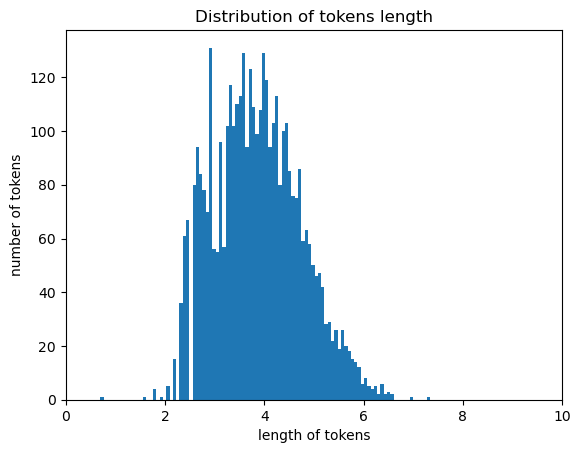

In [27]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [28]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

236

In [29]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9565

**反向tokenize**  
我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [33]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            # text = text + cn_model.index2word[i]
            text = text + cn_model.index_to_key[i]
        else:
            text = text + ' '
    return text

In [34]:
reverse = reverse_tokens(train_tokens[0])

以下可见，训练样本的极性并不是那么精准，比如说下面的样本，对早餐并不满意，但被定义为正面评价，这会迷惑我们的模型，不过我们暂时不对训练样本进行任何修改。

In [35]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [36]:
# 原始文本
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

**准备Embedding Matrix**  
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。  
注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [37]:
embedding_dim

300

In [39]:
# 只使用前20000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    # embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
    embedding_matrix[i,:] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [41]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index_to_key[333]] == embedding_matrix[333] )

300

In [42]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

**padding（填充）和truncating（修剪）**  
我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [43]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [44]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0

In [45]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [46]:
# 准备target向量，前2000样本为1，后2000为0
train_target = np.array(train_target)

In [47]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [48]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [49]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

                                                                                                                                                                                                                        房间很大还有海景阳台走出酒店就是沙滩非常不错唯一遗憾的就是不能刷 不方便
class:  1


现在我们用keras搭建LSTM模型，模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。
keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。   
在Embedding层我们输入的矩阵为：$$(batchsize, maxtokens)$$
输出矩阵为： $$(batchsize, maxtokens, embeddingdim)$$

In [50]:
# 用LSTM对样本进行分类
model = Sequential()

In [51]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

print(embedding_dim)
print(max_tokens)

300
236


In [52]:
# 在2019年6月10日修改了一些大坑的bug, 可能是数据的顺序变了, 
# 结果模型训练的效果没有去年最早的时候效果好了, 
# 有兴趣的同学可以调整一下模型参数, 看看会不会有更好的结果
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

**构建模型**  
我在这个教程中尝试了几种神经网络结构，因为训练样本比较少，所以我们可以尽情尝试，训练过程等待时间并不长：  
**GRU：**如果使用GRU的话，测试样本可以达到87%的准确率，但我测试自己的文本内容时发现，GRU最后一层激活函数的输出都在0.5左右，说明模型的判断不是很明确，信心比较低，而且经过测试发现模型对于否定句的判断有时会失误，我们期望对于负面样本输出接近0，正面样本接近1而不是都徘徊于0.5之间。  
**BiLSTM：**测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，这可能是因为BiLSTM对于比较长的句子结构有更好的记忆，有兴趣的朋友可以深入研究一下。  
Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果。

In [40]:
# GRU的代码
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [55]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
# optimizer = Adam(lr=1e-3)
optimizer = Adam(learning_rate=1e-3)

In [56]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [57]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 236, 300)          15000000  
                                                                 
 bidirectional (Bidirection  (None, 236, 128)          186880    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 16)                9280      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                        

In [60]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [65]:
# import h5py

# file_path = "sentiment_checkpoint.h5"

# if h5py.is_hdf5(file_path):
#     # 文件格式正确，进行打开操作
#     f = h5py.File(file_path, "r")
# else:
#     print("Invalid file format!")


Invalid file format!


In [67]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

# model.load_weights(path_checkpoint)

Unable to open file (file signature not found)


In [68]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [69]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [70]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [ ]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

**结论**  
我们首先对测试样本进行预测，得到了还算满意的准确度。  
之后我们定义一个预测函数，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [84]:
result = model.evaluate(X_test, y_test)
# print("Test loss:", result[0])
print('Accuracy:{0:.2%}'.format(result[1]))

13/13 [==============================] - 1s 62ms/step - loss: 0.6781 - accuracy: 0.5100
Accuracy:51.00%


In [75]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            # cut_list[i] = cn_model.vocab[word].index
            cut_list[i] = cn_model.key_to_index[word]
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [76]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
1/1 [==============================] - 2s 2s/step
是一例负面评价 output=0.46
酒店卫生条件非常不好
1/1 [==============================] - 0s 57ms/step
是一例负面评价 output=0.45
床铺非常舒适
1/1 [==============================] - 0s 56ms/step
是一例负面评价 output=0.47
房间很凉，不给开暖气
1/1 [==============================] - 0s 54ms/step
是一例负面评价 output=0.45
房间很凉爽，空调冷气很足
1/1 [==============================] - 0s 53ms/step
是一例负面评价 output=0.46
酒店环境不好，住宿体验很不好
1/1 [==============================] - 0s 55ms/step
是一例负面评价 output=0.45
房间隔音不到位
1/1 [==============================] - 0s 43ms/step
是一例负面评价 output=0.45
晚上回来发现没有打扫卫生
1/1 [==============================] - 0s 52ms/step
是一例负面评价 output=0.45
因为过节所以要我临时加钱，比团购的价格贵
1/1 [==============================] - 0s 52ms/step
是一例负面评价 output=0.45


**错误分类的文本**
经过查看，发现错误分类的文本的含义大多比较含糊，就算人类也不容易判断极性，如index为101的这个句子，好像没有一点满意的成分，但这例子评价在训练样本中被标记成为了正面评价，而我们的模型做出的负面评价的预测似乎是合理的。

In [77]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

13/13 [==============================] - 1s 66ms/step


In [78]:
y_actual = np.array(y_test)

In [79]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

In [80]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

400


In [81]:
# 我们来找出错误分类的样本看看
idx=101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                        由于2007年 有一些新问题可能还没来得及解决我因为工作需要经常要住那里所以慎重的提出以下 ：1 后 的 淋浴喷头的位置都太高我换了房间还是一样很不好用2 后的一些管理和服务还很不到位尤其是前台入住和 时代效率太低每次 都超过10分钟好像不符合 宾馆的要求
预测的分类 0
实际的分类 1


In [82]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                                                                                 还是很 设施也不错但是 和以前 比急剧下滑了 和客房 的服务极差幸好我不是很在乎
预测的分类 0
实际的分类 1
